In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyfaidx import Fasta
import logomaker
import pandas as pd

In [2]:
# global files
meta_act_file = "/data5/deepro/starrseq/papers/results/2_categorize_fragments_on_activity/data/meta_activity_map.csv"
genome_fasta = "/data5/deepro/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
rna_features_file = "/data5/deepro/starrseq/papers/results/7_cross_library_prediction/data/ATF2/peaks_vs_notpeaks/rna_features.h5"

# library files
nlinear_loc_arr_file = "/data5/deepro/starrseq/papers/results/7_cross_library_prediction/data/ATF2/peaks_vs_notpeaks/non_linear/locations.npy"
nlinear_seq_arr_file = "/data5/deepro/starrseq/papers/results/7_cross_library_prediction/data/ATF2/peaks_vs_notpeaks/non_linear/seq_attr.npy"
nlinear_pred_file = "/data5/deepro/starrseq/papers/results/7_cross_library_prediction/data/ATF2/peaks_vs_notpeaks/non_linear/resnet_mlp.csv.gz"
nlinear_addn_arr_file = "/data5/deepro/starrseq/papers/results/7_cross_library_prediction/data/ATF2/peaks_vs_notpeaks/non_linear/addn_attr.npy"

In [3]:
meta_act_df = pd.read_csv(meta_act_file, low_memory=False)

In [4]:
genome = Fasta(genome_fasta, as_raw=True)

In [38]:
features = pd.read_hdf(rna_features_file, stop=1)
features = np.array(features.columns)[1:]

In [63]:
def read_pred_files(pred_file, seq_arr_file, loc_arr_file, addn_arr_file=None):
    pred_df = pd.read_csv(pred_file, header=None, names=["ypred", "ytarget", "chrm", "start", "end"])
    seq_arr = np.load(seq_arr_file)
    loc_arr = np.load(loc_arr_file)
    addn_arr = None
    if addn_arr_file:
        addn_arr = np.load(addn_arr_file)
    return pred_df, seq_arr, loc_arr, addn_arr

def create_seq_attr_df(seq, seq_attr):
    data_arr = np.zeros((len(seq), 4))
    nts = ["A", "T", "G", "C"]
    seq_idx = dict(zip(nts, range(len(nts))))
    for i, (s, sq) in enumerate(zip(seq, seq_attr)):
        data_arr[i, seq_idx[s]] = sq
    data_df = pd.DataFrame(data_arr, columns=nts)
    return data_df

def get_complement(seq):
    complement_dict = {
        "A": "T",
        "G": "C",
        "T": "A",
        "C": "G",
        "N": "N"
        }    
    rev_comp_seq = "".join([complement_dict[s] for s in seq])
    return rev_comp_seq

def create_seqattr_figure(seq, seq_attr, nrows=5, figsize=(15,10)):
    seq_df = create_seq_attr_df(seq, seq_attr)
    bp_per_row=len(seq)//nrows
    fig, ax = plt.subplots(nrows, 1, figsize=figsize, sharey=True)
    start = 0
    for row in range(nrows):
        # create Logo object
        nn_logo = logomaker.Logo(seq_df.iloc[start:start+bp_per_row], ax=ax[row],)
        nn_logo.ax.set_xticks([])
        start += bp_per_row
        ax[row].spines[['right', 'top', "bottom"]].set_visible(False)
        ax[row].xaxis.set_visible(False)
        # ax[row].set_yticks([])
        ax[row].set_ylim(seq_attr.min(), seq_attr.max())
    return fig, ax

In [8]:
nlinear_pred_df, nlinear_seq_arr, nlinear_loc_arr, nlinear_addn_arr = read_pred_files(nlinear_pred_file, nlinear_seq_arr_file, nlinear_loc_arr_file, nlinear_addn_arr_file)

In [9]:
libraries = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2"]
lib = "ATF2"
peak_lib = f"{lib}_peak"
other_peak_libs = [f"{l}_peak" for l in libraries if l!=lib]

In [86]:
potential_gained = meta_act_df.loc[(meta_act_df.loc[:, other_peak_libs].sum(axis=1)>4)&(meta_act_df[peak_lib]==0)].chrom_coord.str.split("_", expand=True).reset_index(drop=True)
potential_gained.columns = ["chrm", "start", "end"]
potential_gained["start"] = potential_gained.start.astype("int64")
potential_gained["end"] = potential_gained.end.astype("int64")

In [87]:
potential_gained_pred = nlinear_pred_df.reset_index().merge(potential_gained, on=["chrm", "start", "end"])

In [90]:
potential_gained_pred.loc[potential_gained_pred.ypred<0.5].set_index("index").sort_values("ypred")

,ypred,ytarget,chrm,start,end
index,,,,,
226917,0.003656,0,chr18,44789125,44789625
231127,0.004900,0,chr17,15963484,15963984
227779,0.009230,0,chr12,10717097,10717597
231610,0.009759,0,chr7,24970924,24971424
231903,0.012040,0,chr1,162094319,162094819
...,...,...,...,...,...
230352,0.467169,0,chr6,13248292,13248792
231116,0.471071,0,chr5,177269721,177270221
230851,0.483148,0,chr5,174425415,174425915


In [92]:
meta_act_df.loc[(meta_act_df.chrom_coord=="chr18_44789125_44789625"), other_peak_libs]

,CC_peak,CTCF_peak,FOXA1_peak,LEF1_peak,SCRT1_peak,TCF7L2_peak
246060,1,1,1,0,1,1


In [93]:
def get_seq_info(nlinear_pred_df, genome, nlinear_seq_arr, idx, reverse=False):
    chrm, start, end = nlinear_pred_df.iloc[idx].loc[["chrm", "start", "end"]].values
    seq = list(genome.get_seq(chrm, start, end))
    if reverse:
        seq = get_complement(seq)
    seq_attr = nlinear_seq_arr[idx]
    return seq, seq_attr, (chrm, start, end)

def get_gene_info(nlinear_addn_arr, features, idx, reverse=True):
    addn_attr = nlinear_addn_arr[idx]
    best_attr_idxs = np.argsort(addn_attr)
    if reverse:
        best_attr_idxs = best_attr_idxs[::-1]
    return dict(zip(features[best_attr_idxs[:5]], addn_attr[best_attr_idxs[:5]]))

((<Figure size 1500x1000 with 5 Axes>,
  array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>], dtype=object)),
 {'C1QL4': -0.00638313320253863,
  'ENSG00000274964': -0.005933398998580177,
  'SYNGR3': -0.005448425742237084,
  'ZNF783': -0.0054452024118200725,
  'ENSG00000264937': -0.005038748024386549})

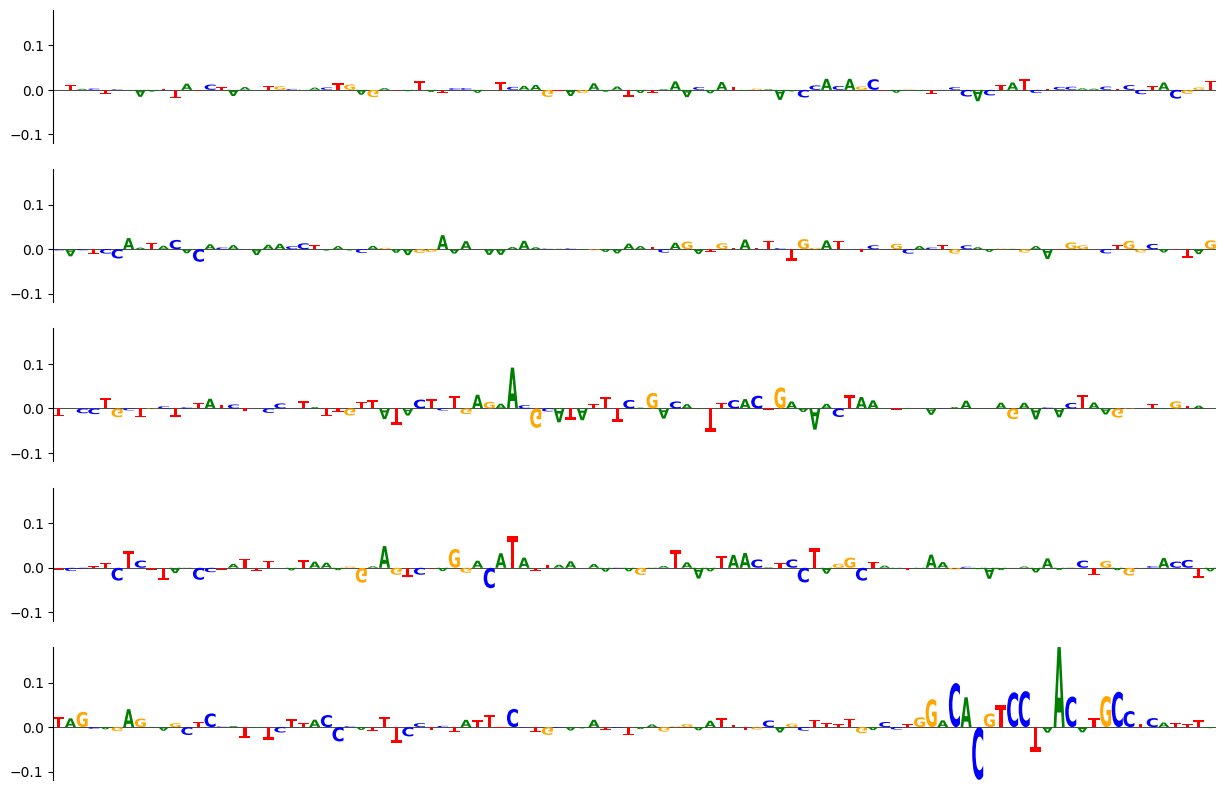

In [98]:
IDX = 227779 # okay results UQCRC1 idx 140 potential gained # good C1QL4 gene giving a negative score to this region although sequence had the signals.
s, sa, (chrm, start, end) = get_seq_info(nlinear_pred_df, genome, nlinear_seq_arr, IDX) 
genes = get_gene_info(nlinear_addn_arr, features, IDX, reverse=False)
create_seqattr_figure(s, sa, nrows=5, figsize=(15, 10)), genes